<a href="https://colab.research.google.com/github/sudarshan-raveendranath/Skin-Lession-Detection/blob/Aashani/skin_lesion_mobilenet_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Lesion Classification — Transfer Learning template
**Dataset:** merged HAM10000 + MSLDv2.0 (14 classes).

This notebook trains a single transfer-learning model on the dataset using PyTorch.
**Assumptions:** dataset arranged like:
```
data/
  train/
    class_1/
      img1.jpg
      img2.jpg
    class_2/
  val/
    class_1/
    ...
```
If your dataset is packaged differently, adapt `train_dir` / `val_dir` variables below.

This notebook was autogenerated to match SE4050 assignment requirements (4 different model notebooks will be provided).
\n\n**Model:** MobileNetV3-Large

In [1]:
# Environment & imports
# If running in a fresh environment, you may need to install packages:
# !pip install torch torchvision matplotlib scikit-learn tqdm timm -q
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [2]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Paths (change these to your dataset locations)
train_dir = "/content/drive/MyDrive/DL Labs/DL/train"
val_dir   = "/content/drive/MyDrive/DL Labs/DL/val"

# Data transforms and augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes ({}):".format(num_classes), class_names)
print("Train size:", len(train_dataset), " Val size:", len(val_dataset))


Classes (10): ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train size: 10648  Val size: 1327


In [4]:
# Compute class weights to address imbalance
from collections import Counter
counts = Counter([y for _, y in train_dataset.samples])
counts = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts)
class_weights = torch.tensor([sum(counts)/c for c in counts], dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [693, 900, 792, 191, 1932, 1368, 660, 3408, 502, 202]
Class weights: tensor([15.3651, 11.8311, 13.4444, 55.7487,  5.5114,  7.7836, 16.1333,  3.1244,
        21.2112, 52.7129])


In [5]:
# MobileNetV3 Large (pretrained)
try:
    model = models.mobilenet_v3_large(pretrained=True)
    # Correctly identify the input features for the classifier
    num_ftrs = model.classifier[-1].in_features  # Access the last layer of the classifier
    model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
except Exception as e:
    # Fallback for older torchvision versions or different model structures
    model = models.mobilenet_v3_large(pretrained=True)
    # Attempt to access the in_features from the first layer if the above fails
    try:
        num_ftrs = model.classifier[0].in_features
        model.classifier[0] = nn.Linear(num_ftrs, num_classes)
    except Exception as e_fallback:
        print(f"Could not adapt classifier automatically: {e_fallback}")
        print("Please check the model's classifier structure and adapt the code manually.")

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 237MB/s]


In [6]:
# Optimizer, scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Optional scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = None
num_epochs = 10  # change as needed


In [7]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=10, model_name="model"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[], "val_f1":[]}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        # Each epoch has a training and validation phase
        for phase in ["train","val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []

            for inputs, labels in tqdm(loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(preds.cpu().numpy().tolist())

            epoch_loss = running_loss / (len(loader.dataset))
            epoch_acc = running_corrects / (len(loader.dataset))
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            print("{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}".format(phase, epoch_loss, epoch_acc, epoch_f1))

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                # deep copy the model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
        if scheduler is not None:
            scheduler.step()
        print("-"*30)

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val F1: {:.4f}".format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [8]:
# Train
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, model_name="MobileNetV3-Large")


Epoch 1/10


100%|██████████| 333/333 [14:29<00:00,  2.61s/it]


train Loss: 1.1417 Acc: 0.5568 F1: 0.5240


100%|██████████| 42/42 [01:52<00:00,  2.68s/it]


val Loss: 0.6070 Acc: 0.7724 F1: 0.7832
------------------------------
Epoch 2/10


100%|██████████| 333/333 [08:59<00:00,  1.62s/it]


train Loss: 0.6433 Acc: 0.7352 F1: 0.7173


100%|██████████| 42/42 [00:23<00:00,  1.75it/s]


val Loss: 0.3935 Acc: 0.8674 F1: 0.8472
------------------------------
Epoch 3/10


100%|██████████| 333/333 [09:08<00:00,  1.65s/it]


train Loss: 0.5068 Acc: 0.7855 F1: 0.7677


100%|██████████| 42/42 [00:25<00:00,  1.68it/s]


val Loss: 0.3549 Acc: 0.8719 F1: 0.8618
------------------------------
Epoch 4/10


100%|██████████| 333/333 [09:07<00:00,  1.65s/it]


train Loss: 0.4403 Acc: 0.8229 F1: 0.8031


100%|██████████| 42/42 [00:23<00:00,  1.78it/s]


val Loss: 0.2657 Acc: 0.8998 F1: 0.8909
------------------------------
Epoch 5/10


100%|██████████| 333/333 [09:07<00:00,  1.64s/it]


train Loss: 0.3761 Acc: 0.8461 F1: 0.8265


100%|██████████| 42/42 [00:24<00:00,  1.71it/s]


val Loss: 0.2457 Acc: 0.9028 F1: 0.8812
------------------------------
Epoch 6/10


100%|██████████| 333/333 [09:12<00:00,  1.66s/it]


train Loss: 0.3490 Acc: 0.8558 F1: 0.8448


100%|██████████| 42/42 [00:24<00:00,  1.69it/s]


val Loss: 0.1928 Acc: 0.9224 F1: 0.8820
------------------------------
Epoch 7/10


100%|██████████| 333/333 [09:11<00:00,  1.66s/it]


train Loss: 0.3286 Acc: 0.8756 F1: 0.8577


100%|██████████| 42/42 [00:24<00:00,  1.70it/s]


val Loss: 0.1892 Acc: 0.9277 F1: 0.9035
------------------------------
Epoch 8/10


100%|██████████| 333/333 [09:02<00:00,  1.63s/it]


train Loss: 0.2869 Acc: 0.8851 F1: 0.8738


100%|██████████| 42/42 [00:24<00:00,  1.72it/s]


val Loss: 0.2298 Acc: 0.9164 F1: 0.8806
------------------------------
Epoch 9/10


100%|██████████| 333/333 [09:10<00:00,  1.65s/it]


train Loss: 0.2699 Acc: 0.8919 F1: 0.8835


100%|██████████| 42/42 [00:24<00:00,  1.70it/s]


val Loss: 0.1489 Acc: 0.9442 F1: 0.9261
------------------------------
Epoch 10/10


100%|██████████| 333/333 [09:07<00:00,  1.64s/it]


train Loss: 0.2666 Acc: 0.8955 F1: 0.8858


100%|██████████| 42/42 [00:24<00:00,  1.73it/s]

val Loss: 0.2013 Acc: 0.9231 F1: 0.8920
------------------------------
Training complete in 102m 9s
Best val F1: 0.9261


In [9]:
def plot_history(history, model_name="model"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{model_name} Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"{model_name} Accuracy")
    plt.show()


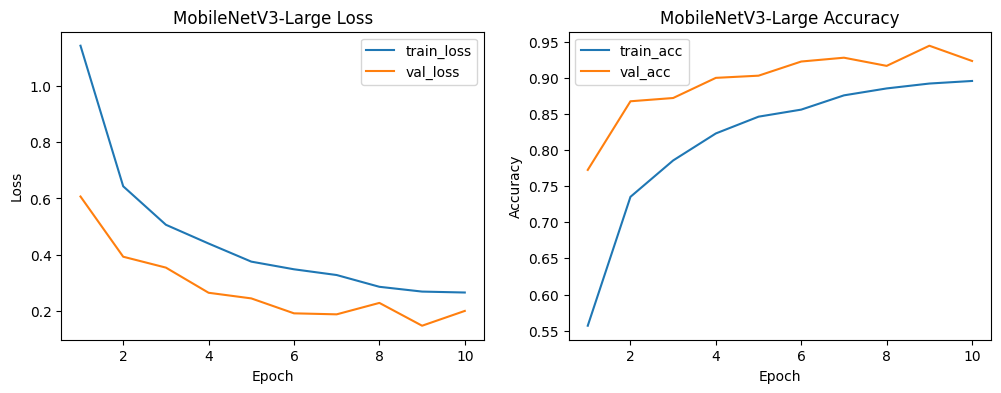

In [10]:
plot_history(history, model_name="MobileNetV3-Large")


In [11]:
# Load best model checkpoint (if needed) and run final evaluation on validation set
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)


## Notes and next steps
- Tune learning rates, batch size, augmentation.
- Consider 5-fold cross validation for robustness.
- Use mixed precision (torch.cuda.amp) to speed up training on large GPUs.
- Save final models and record results in a comparison table.